In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
np.random.RandomState(42)

import time
import datetime as dt
from scipy import stats
import seaborn as sns

from holidays import country_holidays
from sklearn import preprocessing
from pandas_profiling import ProfileReport

Links to external data and license

dataset website: https://dev.meteostat.net/bulk/hourly.html#endpoints

dataset 2020 https://bulk.meteostat.net/v2/hourly/2020/07156.csv.gz

dataset 2021 https://bulk.meteostat.net/v2/hourly/2021/07156.csv.gz

license https://dev.meteostat.net/terms.html#license

In [2]:
#get train and test data
train_data = pd.read_parquet(Path("data") / "train.parquet")
test_data = pd.read_parquet(Path("data") / "test.parquet")

In [3]:
train_data.dtypes

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
bike_count                          float64
date                         datetime64[ns]
counter_installation_date    datetime64[ns]
counter_technical_id               category
latitude                            float64
longitude                           float64
log_bike_count                      float64
dtype: object

In [4]:
test_data.dtypes

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
bike_count                          float64
date                         datetime64[ns]
counter_installation_date    datetime64[ns]
counter_technical_id               category
latitude                            float64
longitude                           float64
log_bike_count                      float64
dtype: object

In [5]:
train_data.describe()

,site_id,bike_count,latitude,longitude,log_bike_count
count,4.551630e+05,455163.000000,455163.000000,455163.000000,455163.000000
mean,1.051759e+08,59.483596,48.854357,2.345529,3.048589
std,3.160033e+07,87.129357,0.018559,0.038013,1.675059
min,1.000070e+08,0.000000,48.826360,2.265420,0.000000
25%,1.000475e+08,4.000000,48.840801,2.314440,1.609438
50%,1.000562e+08,28.000000,48.852090,2.353870,3.367296
75%,1.000563e+08,79.000000,48.864610,2.375870,4.382027
max,3.000147e+08,1275.000000,48.891720,2.409690,7.151485


In [6]:
test_data.describe()

,site_id,bike_count,latitude,longitude,log_bike_count
count,4.160800e+04,41608.000000,41608.000000,41608.000000,41608.000000
mean,1.071923e+08,68.010118,48.854193,2.344938,3.424965
std,3.710914e+07,92.159284,0.018505,0.038158,1.439106
min,1.000070e+08,0.000000,48.826360,2.265420,0.000000
25%,1.000475e+08,11.000000,48.840543,2.313777,2.484907
50%,1.000563e+08,37.000000,48.851110,2.353870,3.637586
75%,1.000563e+08,87.000000,48.863988,2.375539,4.477337
max,3.000147e+08,1302.000000,48.891720,2.409690,7.172425


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41608 entries, 56474 to 929187
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   counter_id                 41608 non-null  category      
 1   counter_name               41608 non-null  category      
 2   site_id                    41608 non-null  int64         
 3   site_name                  41608 non-null  category      
 4   bike_count                 41608 non-null  float64       
 5   date                       41608 non-null  datetime64[ns]
 6   counter_installation_date  41608 non-null  datetime64[ns]
 7   counter_technical_id       41608 non-null  category      
 8   latitude                   41608 non-null  float64       
 9   longitude                  41608 non-null  float64       
 10  log_bike_count             41608 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), int64(1)
memory

In [9]:
#generate profiling report for each dataset
prof = ProfileReport(train_data)
prof = ProfileReport(test_data)
prof.to_file(output_file='profiling/train.html')
prof.to_file(output_file='profiling/test.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
#get external(weather) data for 2020 and 2021
df1 = pd.read_csv(Path("Final_Files") / "2020.csv")
df1 = pd.read_csv(Path("Final_Files") / "2021.csv")

In [11]:
df1.dtypes

date     object
hour      int64
temp    float64
dwpt    float64
rhum      int64
prcp    float64
snow    float64
wdir    float64
wspd    float64
wpgt    float64
pres    float64
tsun    float64
coco    float64
dtype: object

In [12]:
df2.dtypes

date     object
hour      int64
temp    float64
dwpt    float64
rhum      int64
prcp    float64
snow    float64
wdir      int64
wspd    float64
wpgt    float64
pres    float64
tsun    float64
Coco    float64
dtype: object

In [13]:
df1.describe()

,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
count,8656.000000,8654.000000,8654.000000,8656.000000,5402.000000,0.0,8655.000000,8656.000000,0.0,8652.000000,0.0,0.0
mean,11.492722,13.974081,7.531916,68.532232,0.082469,NaN,190.010399,11.588424,NaN,1016.608229,NaN,NaN
std,6.924930,6.863037,4.940448,18.629394,0.551491,NaN,99.290934,5.502824,NaN,9.599778,NaN,NaN
min,0.000000,-1.000000,-11.000000,17.000000,0.000000,NaN,0.000000,0.000000,NaN,972.200000,NaN,NaN
25%,5.000000,8.700000,4.100000,55.000000,0.000000,NaN,110.000000,7.600000,NaN,1011.900000,NaN,NaN
50%,11.000000,13.300000,7.700000,72.000000,0.000000,NaN,210.000000,11.200000,NaN,1017.400000,NaN,NaN
75%,17.000000,18.700000,11.100000,84.000000,0.000000,NaN,260.000000,14.800000,NaN,1022.200000,NaN,NaN
max,23.000000,38.800000,22.600000,100.000000,18.000000,NaN,360.000000,44.600000,NaN,1047.800000,NaN,NaN


In [14]:
df2.describe()

,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,Coco
count,8760.000000,8760.000000,8760.000000,8760.000000,8754.000000,0.0,8760.000000,8760.000000,0.0,8760.000000,0.0,0.0
mean,11.500000,12.503231,6.916107,71.031050,0.090107,NaN,181.594635,11.030263,NaN,1017.443505,NaN,NaN
std,6.922582,6.804329,5.932135,16.217572,0.460113,NaN,104.978263,5.060598,NaN,8.952942,NaN,NaN
min,0.000000,-6.400000,-17.100000,19.000000,0.000000,NaN,0.000000,0.000000,NaN,987.700000,NaN,NaN
25%,5.750000,7.500000,2.700000,59.000000,0.000000,NaN,70.000000,7.600000,NaN,1012.000000,NaN,NaN
50%,11.500000,11.900000,7.000000,74.000000,0.000000,NaN,200.000000,11.200000,NaN,1018.500000,NaN,NaN
75%,17.250000,17.500000,11.800000,84.000000,0.000000,NaN,260.000000,14.800000,NaN,1023.800000,NaN,NaN
max,23.000000,32.900000,20.700000,99.000000,16.000000,NaN,360.000000,42.500000,NaN,1039.500000,NaN,NaN


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8656 entries, 0 to 8655
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8656 non-null   object 
 1   hour    8656 non-null   int64  
 2   temp    8654 non-null   float64
 3   dwpt    8654 non-null   float64
 4   rhum    8656 non-null   int64  
 5   prcp    5402 non-null   float64
 6   snow    0 non-null      float64
 7   wdir    8655 non-null   float64
 8   wspd    8656 non-null   float64
 9   wpgt    0 non-null      float64
 10  pres    8652 non-null   float64
 11  tsun    0 non-null      float64
 12  coco    0 non-null      float64
dtypes: float64(10), int64(2), object(1)
memory usage: 879.2+ KB


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8760 non-null   object 
 1   hour    8760 non-null   int64  
 2   temp    8760 non-null   float64
 3   dwpt    8760 non-null   float64
 4   rhum    8760 non-null   int64  
 5   prcp    8754 non-null   float64
 6   snow    0 non-null      float64
 7   wdir    8760 non-null   int64  
 8   wspd    8760 non-null   float64
 9   wpgt    0 non-null      float64
 10  pres    8760 non-null   float64
 11  tsun    0 non-null      float64
 12  Coco    0 non-null      float64
dtypes: float64(9), int64(3), object(1)
memory usage: 889.8+ KB


We see that there are some missing values in both external data files. We remove such columns that have all missing values and for rest of them we fill the missing values using bfill

In [17]:
df1 = df1.drop(columns=['snow', 'wpgt','tsun','coco'], axis=1)
df1 = df1.fillna(method='bfill')

In [18]:
df2 = df2.drop(columns=['snow', 'wpgt','tsun','Coco'], axis=1)
df2 = df2.fillna(method='bfill')

> Apart from weather, the cyclist traffic will also depend on specific days such as weekday/weekend of public hoplidays, so we will add that data accordingly

In [19]:
#list of public holidays in both years to label if a given day is holiday or not
public_holi20 = country_holidays('FR', subdiv='La Réunion', years=[2020])
public_holi21 = country_holidays('FR', subdiv='La Réunion', years=[2021])

In [20]:
# for 2020 add holiday and weekend column, replace true and false as 1 and 0
df1["date"] = pd.to_datetime(df1["date"])
df1['holiday'] = df1['date'].isin(public_holi20)
df1.holiday = df1.holiday.replace([True, False], [1, 0])
df1.loc[:, "weekday"] = df1["date"].dt.weekday
df1['weekend'] = df1['weekday'].isin([5,6])
df1.weekend = df1.weekend.replace([True, False], [1, 0])
df1 = df1.drop('weekday', axis=1)
df1

,date,hour,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend
0,2020-01-01,0,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0
1,2020-01-01,1,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0
2,2020-01-01,2,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0
3,2020-01-01,3,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0
4,2020-01-01,4,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0
...,...,...,...,...,...,...,...,...,...,...,...
8651,2020-12-31,19,4.0,0.2,76,0.0,300.0,7.6,1006.3,0,0
8652,2020-12-31,20,3.2,-0.1,79,0.0,310.0,5.4,1006.6,0,0
8653,2020-12-31,21,3.0,-0.3,79,0.0,330.0,7.6,1007.0,0,0
8654,2020-12-31,22,2.5,-0.4,81,0.0,280.0,5.4,1007.5,0,0


In [21]:
#do the same above process for 2021
df2["date"] = pd.to_datetime(df2["date"])
df2['holiday'] = df2['date'].isin(public_holi21)
df2.holiday = df2.holiday.replace([True, False], [1, 0])
df2.loc[:, "weekday"] = df2["date"].dt.weekday
df2['weekend'] = df2['weekday'].isin([5,6])
df2.weekend = df2.weekend.replace([True, False], [1, 0])
df2 = df2.drop('weekday', axis=1)
df2

,date,hour,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend
0,2021-01-01,0,1.6,-0.8,84,0.0,280,7.6,1008.0,1,0
1,2021-01-01,1,1.4,-1.0,84,0.0,280,5.4,1008.2,1,0
2,2021-01-01,2,0.9,-1.2,86,0.0,280,5.4,1008.6,1,0
3,2021-01-01,3,0.8,-1.1,87,0.0,280,5.4,1008.9,1,0
4,2021-01-01,4,0.6,-1.3,87,0.0,310,3.6,1009.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31,19,11.9,10.3,90,0.0,250,5.4,1026.5,0,0
8756,2021-12-31,20,12.0,10.6,91,0.0,280,11.2,1026.6,0,0
8757,2021-12-31,21,12.2,10.9,92,0.0,280,7.6,1026.6,0,0
8758,2021-12-31,22,12.0,10.6,91,0.0,270,3.6,1026.7,0,0


In [22]:
#merge weather data for both years
weather = pd.concat([df1, df2], ignore_index=True)

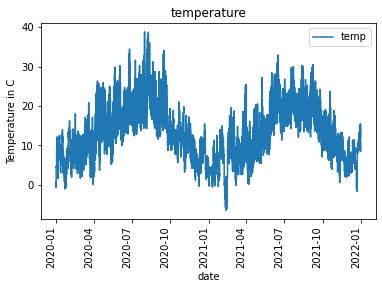

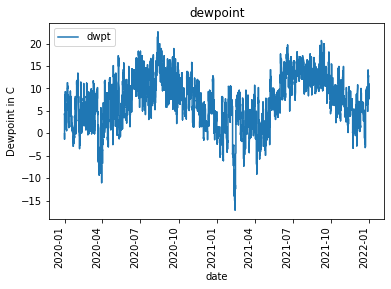

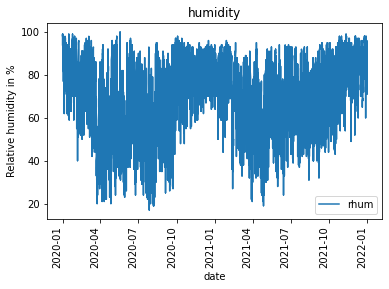

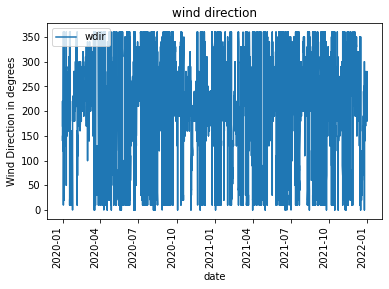

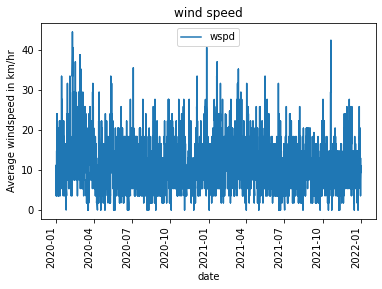

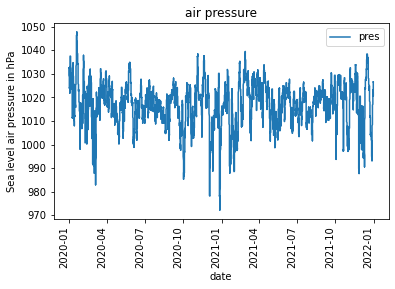

In [23]:
def plot_by_time(weather,column,main_title,yaxis):
    """
    Plot values by timestamp.
    Input:
    weather - pandas DataFrame
    column - name of the column to plot
    main_title - string for title of the plot
    yaxis -string for yaxis label
    
    """
    ax = weather.plot(x='date',y=column, rot=90)
    plt.title(main_title)
    plt.ylabel(yaxis)
    plt.show()

#ax.set_xticklabels(pd.to_datetime(london.timestamp), rotation=90)
plot_by_time(weather,'temp','temperature','Temperature in C')
plot_by_time(weather,'dwpt','dewpoint','Dewpoint in C')
plot_by_time(weather,'rhum','humidity','Relative humidity in %')
plot_by_time(weather,'wdir','wind direction','Wind Direction in degrees')
plot_by_time(weather,'wspd','wind speed','Average windspeed in km/hr')
plot_by_time(weather,'pres','air pressure','Sea level air pressure in hPa')

In [24]:
weather

,date,hour,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend
0,2020-01-01,0,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0
1,2020-01-01,1,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0
2,2020-01-01,2,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0
3,2020-01-01,3,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0
4,2020-01-01,4,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0
...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31,19,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0
17412,2021-12-31,20,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0
17413,2021-12-31,21,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0
17414,2021-12-31,22,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0


In [25]:
lock1 = pd.date_range(start='10/30/2020', end='12/02/2020', freq='H').tolist()
lock2 = pd.date_range(start='04/03/2021', end='07/01/2021', freq='H').tolist()

> The bike count in years 2020 and 2021 would have also been affected by the lockdowns imposed in the country. Therefore we take into consideration that data too

In [26]:
weather['lockdown1'] = weather['date'].isin(lock1)
weather.lockdown1 = weather.lockdown1.replace([True, False], [1, 0])
weather['lockdown2'] = weather['date'].isin(lock2)
weather.lockdown2 = weather.lockdown2.replace([True, False], [1, 0])

In [27]:
weather

,date,hour,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,lockdown1,lockdown2
0,2020-01-01,0,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0,0,0
1,2020-01-01,1,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,0,0
2,2020-01-01,2,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,0,0
3,2020-01-01,3,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0,0,0
4,2020-01-01,4,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31,19,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,0,0
17412,2021-12-31,20,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,0,0
17413,2021-12-31,21,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,0,0
17414,2021-12-31,22,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,0,0


In [28]:
# add season as a numerical column depending on the month of the year
"""
mapping:
0 - spring
1 - summer
2 - fall
3 - winter
"""
weather.loc[:, "season"] = weather["date"].dt.month
weather_dict = {1 : 3,  2 : 3,  3 : 3,  4 : 0, 5 : 0,
                6 : 1, 7 : 1, 8 : 1, 9 : 1, 10 : 2, 11 : 2, 12 : 3}
weather.season = weather.season.replace(weather_dict)
weather

,date,hour,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,lockdown1,lockdown2,season
0,2020-01-01,0,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0,0,0,3
1,2020-01-01,1,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,0,0,3
2,2020-01-01,2,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,0,0,3
3,2020-01-01,3,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0,0,0,3
4,2020-01-01,4,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31,19,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,0,0,3
17412,2021-12-31,20,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,0,0,3
17413,2021-12-31,21,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,0,0,3
17414,2021-12-31,22,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,0,0,3


In [29]:
train_data.loc[:, "hour"] = train_data["date"].dt.hour
train_data[train_data['log_bike_count']<3.5].groupby(by='hour').count()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
hour,,,,,,,,,,,
0,18440,18440,18440,18440,18440,18440,18440,18440,18440,18440,18440
1,18861,18861,18861,18861,18861,18861,18861,18861,18861,18861,18861
2,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944
3,18958,18958,18958,18958,18958,18958,18958,18958,18958,18958,18958
4,18222,18222,18222,18222,18222,18222,18222,18222,18222,18222,18222
5,13690,13690,13690,13690,13690,13690,13690,13690,13690,13690,13690
6,8035,8035,8035,8035,8035,8035,8035,8035,8035,8035,8035
7,5553,5553,5553,5553,5553,5553,5553,5553,5553,5553,5553
8,5563,5563,5563,5563,5563,5563,5563,5563,5563,5563,5563


> The grouping above shows that hourly grouping is separating the two distributions. The daylight could be a crucial factor that is creating two distributions of the data. A new column "is_night" is created that is approximately separating the data.

In [30]:
weather['is_night'] = 0
weather.loc[(weather['hour'] < 6) | (weather['hour'] > 19), 'is_night'] = 1
weather

,date,hour,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,lockdown1,lockdown2,season,is_night
0,2020-01-01,0,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0,0,0,3,1
1,2020-01-01,1,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,0,0,3,1
2,2020-01-01,2,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,0,0,3,1
3,2020-01-01,3,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0,0,0,3,1
4,2020-01-01,4,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31,19,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,0,0,3,0
17412,2021-12-31,20,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,0,0,3,1
17413,2021-12-31,21,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,0,0,3,1
17414,2021-12-31,22,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,0,0,3,1


In [31]:
train_data = train_data.drop('hour', axis=1)

In [32]:
weather["hour"] = pd.to_timedelta(weather['hour'], unit='h')
weather['date'] = weather['date'] + weather['hour']
weather = weather.drop(columns=['hour'], axis=1)
weather

,date,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,lockdown1,lockdown2,season,is_night
0,2020-01-01 00:00:00,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0,0,0,3,1
1,2020-01-01 01:00:00,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,0,0,3,1
2,2020-01-01 02:00:00,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,0,0,3,1
3,2020-01-01 03:00:00,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0,0,0,3,1
4,2020-01-01 04:00:00,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31 19:00:00,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,0,0,3,0
17412,2021-12-31 20:00:00,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,0,0,3,1
17413,2021-12-31 21:00:00,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,0,0,3,1
17414,2021-12-31 22:00:00,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,0,0,3,1


In [33]:
#save as a new external data file from the processed dataframe
weather.to_csv('external_data_no_cyc.csv', date_format='%Y-%m-%d %H:%M:%S')

In [34]:
#generate profiling report for weather with no cyclical data encoding
prof = ProfileReport(weather)
prof.to_file(output_file='profiling/external.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

> Since month and hours are cyclical features i.e. the times 0 and 23 in hour are actually quite close in contrast to the numbers assigned to them, we will encode these features using sin and cos

In [35]:
weather['month'] = weather['date'].dt.month
weather['hour'] = weather['date'].dt.hour
weather['hour_sin'] = np.sin(2 * np.pi * weather['hour'] / 23)
weather['hour_cos'] = np.cos(2 * np.pi * weather['hour'] / 23)
weather['month_sin'] = np.sin(2 * np.pi * weather['month'] / 12)
weather['month_cos'] = np.cos(2 * np.pi * weather['month'] / 12)
weather = weather.drop(columns=['month'])

In [36]:
#converted date in external data to match the format with that in training data provided
weather["hour"] = pd.to_timedelta(weather['hour'], unit='h')
weather['date'] = weather['date'] + weather['hour']
weather = weather.drop(columns=['hour'])

In [37]:
#display the final external dataset
weather

,date,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,lockdown1,lockdown2,season,is_night,hour_sin,hour_cos,month_sin,month_cos
0,2020-01-01 00:00:00,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0,0,0,3,1,0.000000e+00,1.000000,5.000000e-01,0.866025
1,2020-01-01 02:00:00,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,0,0,3,1,2.697968e-01,0.962917,5.000000e-01,0.866025
2,2020-01-01 04:00:00,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,0,0,3,1,5.195840e-01,0.854419,5.000000e-01,0.866025
3,2020-01-01 06:00:00,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0,0,0,3,1,7.308360e-01,0.682553,5.000000e-01,0.866025
4,2020-01-01 08:00:00,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,0,0,3,1,8.878852e-01,0.460065,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2022-01-01 14:00:00,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,0,0,3,0,-8.878852e-01,0.460065,-2.449294e-16,1.000000
17412,2022-01-01 16:00:00,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,0,0,3,1,-7.308360e-01,0.682553,-2.449294e-16,1.000000
17413,2022-01-01 18:00:00,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,0,0,3,1,-5.195840e-01,0.854419,-2.449294e-16,1.000000
17414,2022-01-01 20:00:00,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,0,0,3,1,-2.697968e-01,0.962917,-2.449294e-16,1.000000


In [38]:
#save as a new external data file from the processed dataframe
weather.to_csv('external_data_with_cyc.csv', date_format='%Y-%m-%d %H:%M:%S')

In [39]:
#generate a new profiling report for weather with cyclical data
prof = ProfileReport(weather)
prof.to_file(output_file='profiling/external_w_cyc.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
#merge train and test data with external on basis of date column
train_merged = train_data.merge(weather, on='date')
test_merged = test_data.merge(weather, on='date')

> Let us see the distributions of few of the numerical columns in  our dataset

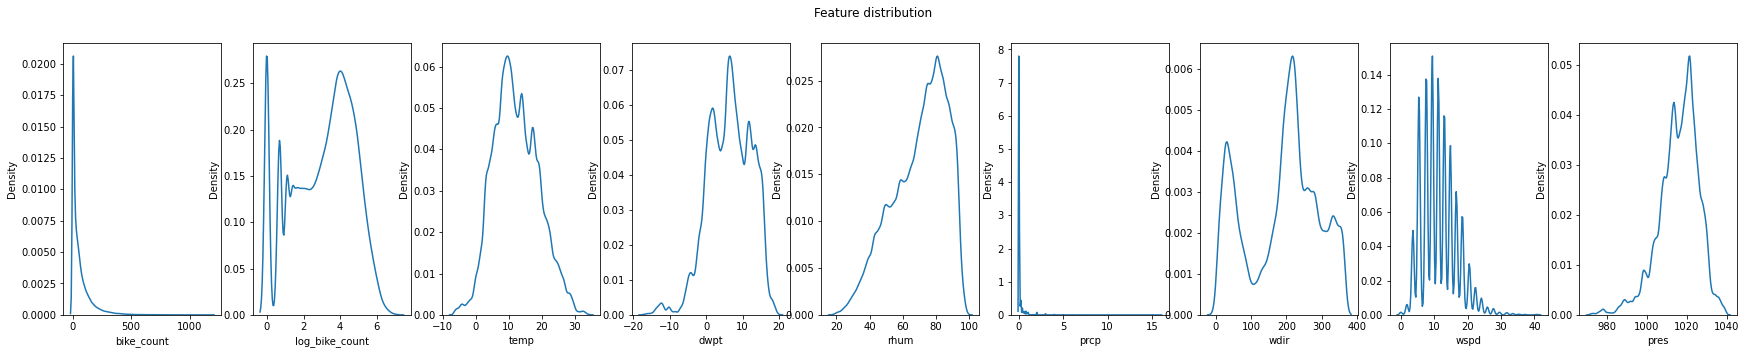

In [41]:
cols = ['bike_count','log_bike_count','temp','dwpt','rhum','prcp','wdir','wspd','pres']
def plot_distribution(data,columns,**kwargs ):
    """
    Function to plot a dataframe feature distribution.
    Input: 
    df - pandas DataFrame.
    columns - list of the df columns that should be plotted
    Output: multiple feature histograms
    
    """
    
    fig, axes = plt.subplots(ncols=len(columns),figsize=(30,5))
    for axs, col in zip(axes, columns):
        sns.kdeplot(data, ax=axs, x=col)
        #sns.histplot(data,ax=axs, x=col, kde=True, bins=50, binwidth=5)
    fig.suptitle('Feature distribution')
    
plot_distribution(train_merged,cols, kde=False)

> We can also see the variations in bike count depending on whether its a weekday/weekend/holiday

In [42]:
train_merged_non_weekend = train_merged[train_merged['weekend'] == 0]
train_merged_non_weekend = train_merged_non_weekend.drop(['holiday','weekend'],axis=1)
train_merged_is_weekend = train_merged[train_merged['weekend'] == 1]
train_merged_is_weekend = train_merged_is_weekend.drop(['holiday','weekend'],axis=1)
train_merged_is_holiday = train_merged[train_merged['holiday'] == 1]
train_merged_is_holiday = train_merged_is_holiday.drop(['holiday','weekend'],axis=1)
train_merged_non_holiday = train_merged[train_merged['holiday'] == 0]
train_merged_non_holiday = train_merged_non_holiday.drop(['holiday','weekend'],axis=1)


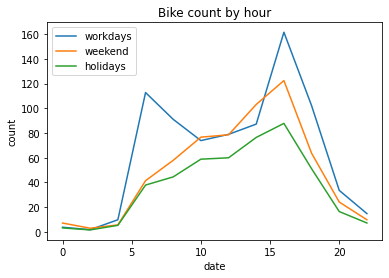

In [43]:
def hourly_plot(df,title):
    
    df.groupby(by=df.date.dt.hour)['bike_count'].mean().plot()
    plt.title(title)
    plt.ylabel('count')
    plt.legend(['workdays','weekend','holidays'],loc=2, fontsize = 'medium')
    
hourly_plot(train_merged_non_weekend, 'Bike count by hour')
hourly_plot(train_merged_is_weekend, 'Bike count by hour')
hourly_plot(train_merged_is_holiday, 'Bike count by hour')


> Correlation between various columns and 'log_bike_count'

In [44]:
corr = train_merged.corr()
corr_bike_count = corr['log_bike_count']
print(corr_bike_count)

site_id           0.019872
bike_count        0.738237
latitude          0.108380
longitude         0.044525
log_bike_count    1.000000
temp              0.116834
dwpt              0.121834
rhum             -0.005959
prcp             -0.015918
wdir             -0.014728
wspd             -0.097540
pres              0.032145
holiday          -0.046722
weekend          -0.070707
lockdown1        -0.044950
lockdown2         0.024604
season           -0.097064
is_night         -0.099998
hour_sin          0.025339
hour_cos          0.018828
month_sin        -0.108655
month_cos        -0.110986
Name: log_bike_count, dtype: float64


<AxesSubplot:>

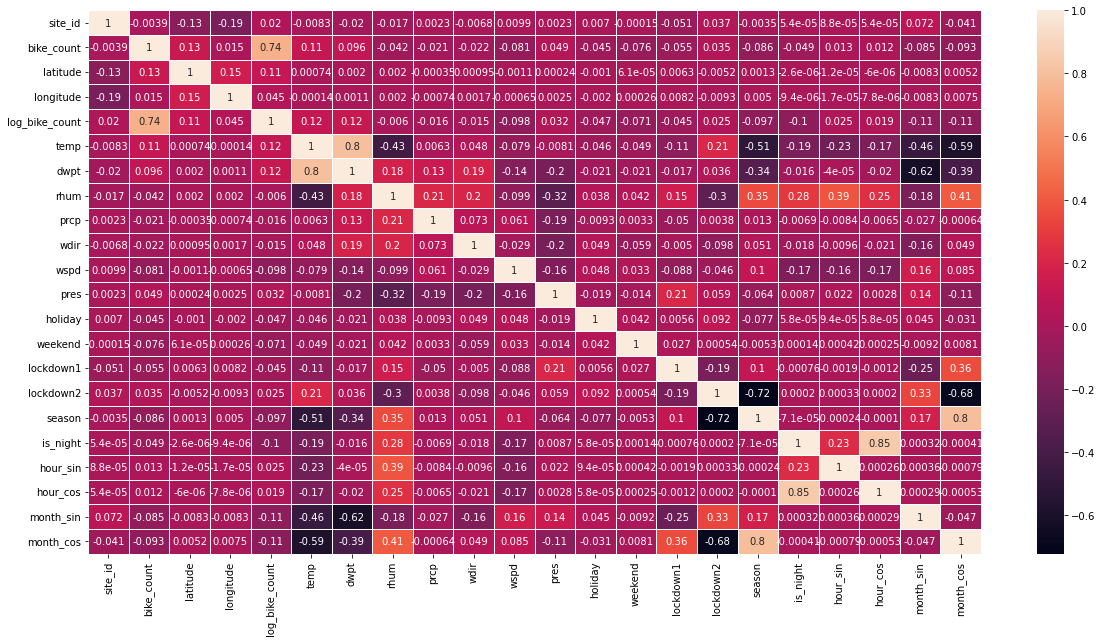

In [45]:
plt.figure(figsize = (20,10))
sns.heatmap(corr, linewidths=1, annot=True)

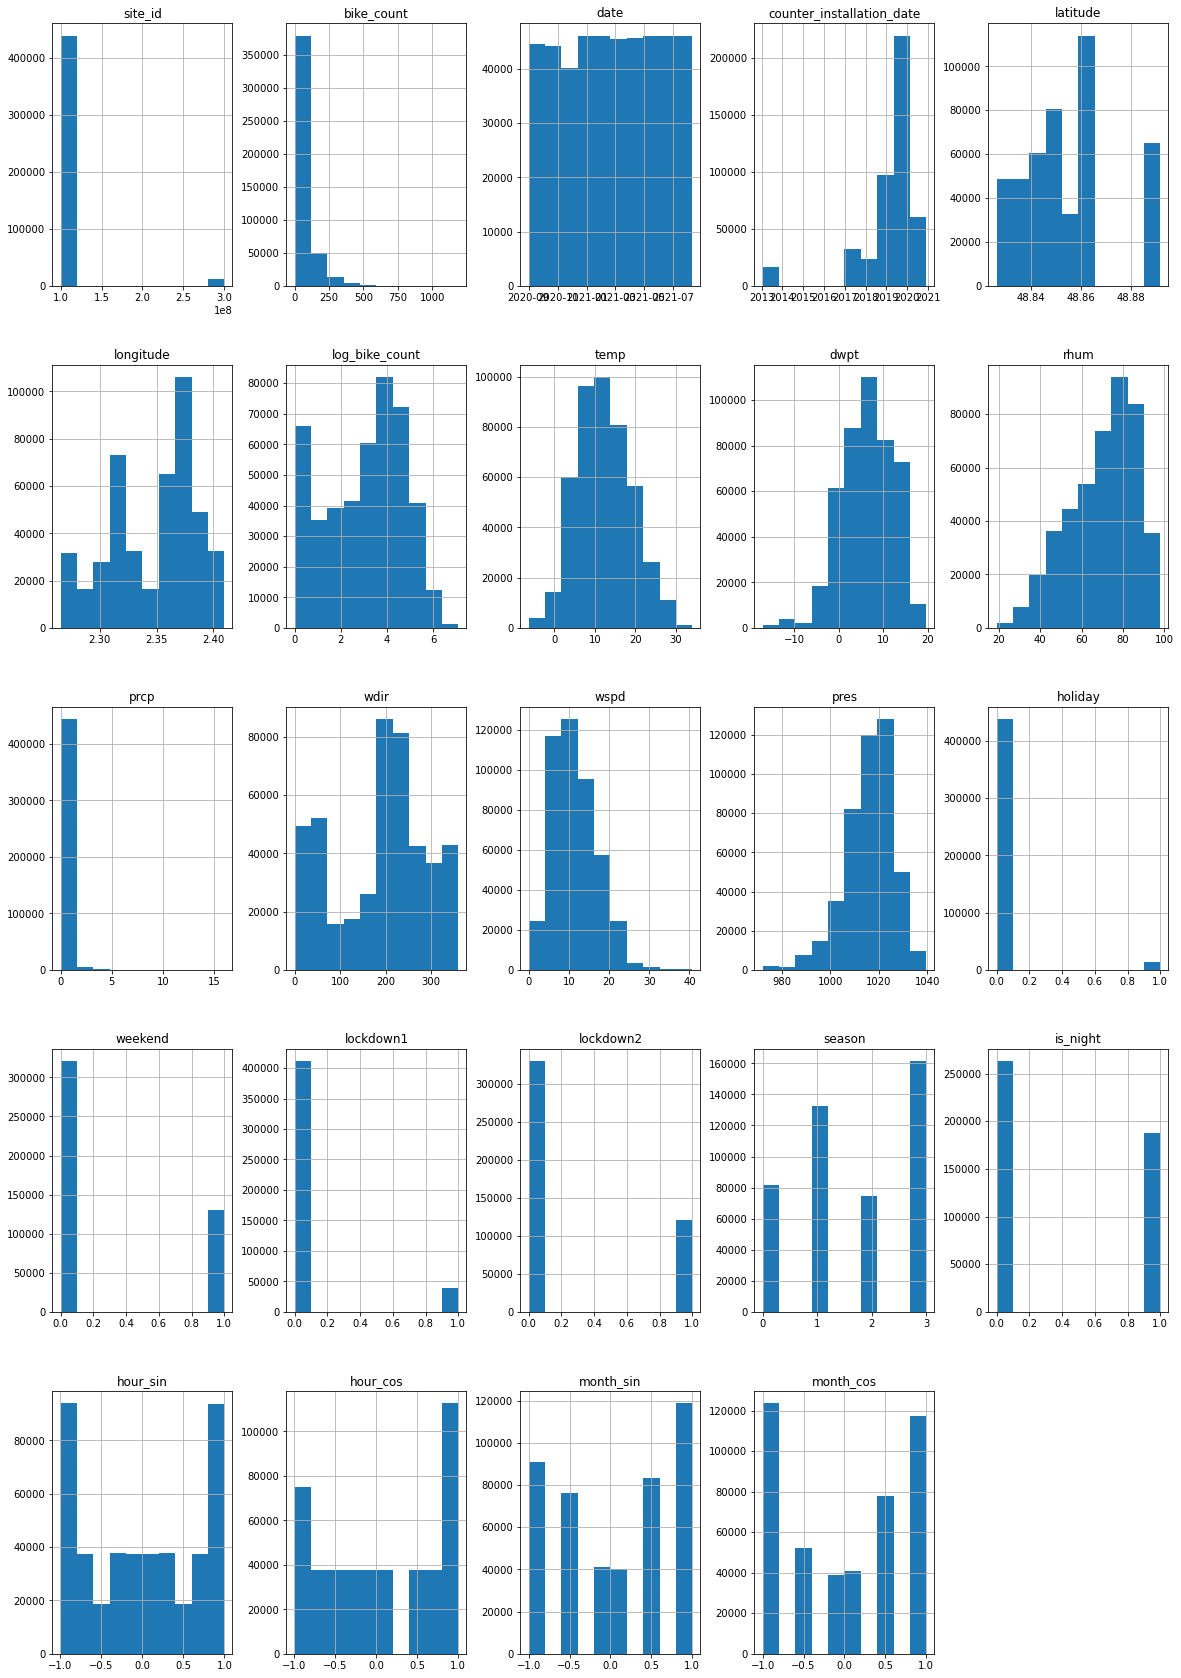

In [46]:
plot = train_merged.hist(figsize=(20, 30))